# Cloudbow analysis


This notebook analyses the effect cloudbow properties and the relation to the microphysical properties of the medium. 

---

Relevant papers:
- François‐Marie Bréon  Philippe Goloub, "Cloud droplet effective radius from spaceborne polarization measurements", 1998. https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/98GL01221
- F.M. Breon, M. Doutriaux-Boucher, "A comparison of cloud droplet radii measured from space", 2005. https://ieeexplore.ieee.org/document/1487637

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

import shdom

## Mie scattering

In [4]:
wavelengths = [0.443, 0.67, 0.865]

veff = 0.02
alpha = 1.0/veff - 3.0
directory = '../mie_tables/veff_{:.3f}'.format(veff)

if not os.path.exists(directory):
    os.makedirs(directory)

In [5]:
mie = shdom.MiePolarized()
mie.set_parameters((0.443, 0.443), 'Water', 'gamma', alpha)
mie.compute_table(50, 5.0, 10.0, 30.0, False)
mie._wigcoef

Computing mie table...
Done.
Writing mie table to file: ../mie_tables/veff_0.020/Water_443nm_pol.scat
Done.


In [ ]:
"""
Generate and save new Mie tables
"""
mie = shdom.MiePolarized()
    
for wavelen in wavelengths:
    mie.set_parameters((wavelen, wavelen), 'Water', 'gamma', 97.0)
    mie.compute_table(50, 5.0, 20.0, 60.0, False)
    output_path = os.path.join(directory, 'Water_{:d}nm_pol.scat'.format(int(wavelen*1000)))
    mie.write_table(output_path)

In [4]:
"""
Load existing Mie tables
"""
mie_list = []
for wavelen in wavelengths:
    input_path = os.path.join(directory, 'Water_{:d}nm_pol.scat'.format(int(wavelen*1000)))
    mie = shdom.MiePolarized()
    mie.read_table(input_path)
    mie_list.append(mie)

Reading mie table from file: ../mie_tables/veff_0.01/Water_443nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.01/Water_670nm_pol.scat
Done.
Reading mie table from file: ../mie_tables/veff_0.01/Water_865nm_pol.scat
Done.


In [ ]:
mie_list[0]

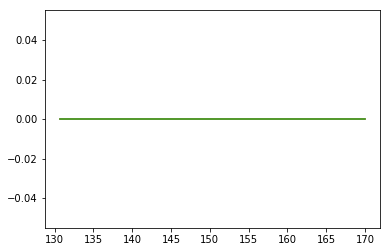

In [6]:
"""
Plot polarized scattering phase function
"""
plot_index = 17
plot_re = mie.reff[plot_index]
angles = np.linspace(0,180, 180)
zoom_range = range(130,170)

%matplotlib inline
plt.figure()
for wavelen, mie in zip(wavelengths, mie_list):
    phase = mie.transform_wignerd_to_phase(plot_index, 5, angles)
    plt.plot(angles[zoom_range], phase[zoom_range])

## Stcu cloudbow

In [2]:
"""
Load a Stratocumulus cloud field from SHDOM original distribution.
The atmosphere containts both Rayleigh and Mie scattering.
"""

# Mie scattering for water droplets
mie = shdom.MiePolarized()
mie.read_table(file_path='../mie_tables/Water_800nm_pol.scat')


# Generate a Microphysical medium
csv_path = '../synthetic_cloud_fields/shdom/les_stcu.txt'
microphysics = shdom.MicrophysicalMedium()
microphysics.load_from_csv(csv_path)

# Rayleigh scattering for air molecules
temperatures = np.array([283.64, 283.41, 283.17, 282.94, 282.72, 282.50, 282.29, 282.11, 
                         281.95, 281.82, 281.69, 281.58, 281.50, 281.71, 283.87, 286.190])
temp_grid = shdom.Grid(z=microphysics.grid.z)
temperature_profile = shdom.GridData(temp_grid, temperatures)
rayleigh = shdom.RayleighPolarized(wavelength=0.8)
rayleigh.init_temperature_profile(temperature_profile)

cloud = shdom.Medium()
air = shdom.AmbientMedium()
    
extinction_c, albedo_c, phase_c = mie.interpolate_scattering_field(microphysics.lwc, microphysics.reff, phase_type='Tabulated')
extinction_a, albedo_a, phase_a = rayleigh.get_scattering_field(temp_grid, phase_type='Tabulated')

cloud.set_optical_properties(extinction_c, albedo_c, phase_c)
air.set_optical_properties(extinction_a, albedo_a, phase_a)
    
atmosphere = cloud + air

Reading mie table from file: ../mie_tables/Water_800nm_pol.scat
Done.


In [4]:
"""
Define the numerical and scene parameter and Solve the 
Polarized Radiative Transfer for the domain using SHDOM: SOLVE_RTE procedure 
(src/polarized/shdomsub1.f).
"""
numerical_params = shdom.NumericalParameters()
scene_params = shdom.SceneParameters(
    wavelength=0.8,
    source=shdom.SolarSource(azimuth=30, zenith=120),
    boundary_conditions={'y': shdom.BoundaryCondition.periodic, 
                         'x': shdom.BoundaryCondition.periodic},
)

rte_solver = shdom.RteSolverPolarized(3, scene_params, numerical_params)
rte_solver.init_medium(atmosphere)
rte_solver.solve(maxiter=2)

In [7]:
"""
Define a camera projection model and render the stokes componenets
"""
projection = shdom.OrthographicProjection(
    bounding_box=cloud.bounding_box, 
    x_resolution=0.02, 
    y_resolution=0.02, 
    azimuth=0.0, 
    zenith=0.0,
    altitude='TOA'
)

camera = shdom.Camera(shdom.PolarizationSensor(), projection)
    
stokes, dolp, aolp, docp = camera.render(rte_solver)

'\nDefine a camera projection model and render the stokes componenets\n'

'\nSimulated cloudbow using a perspective camera\n'

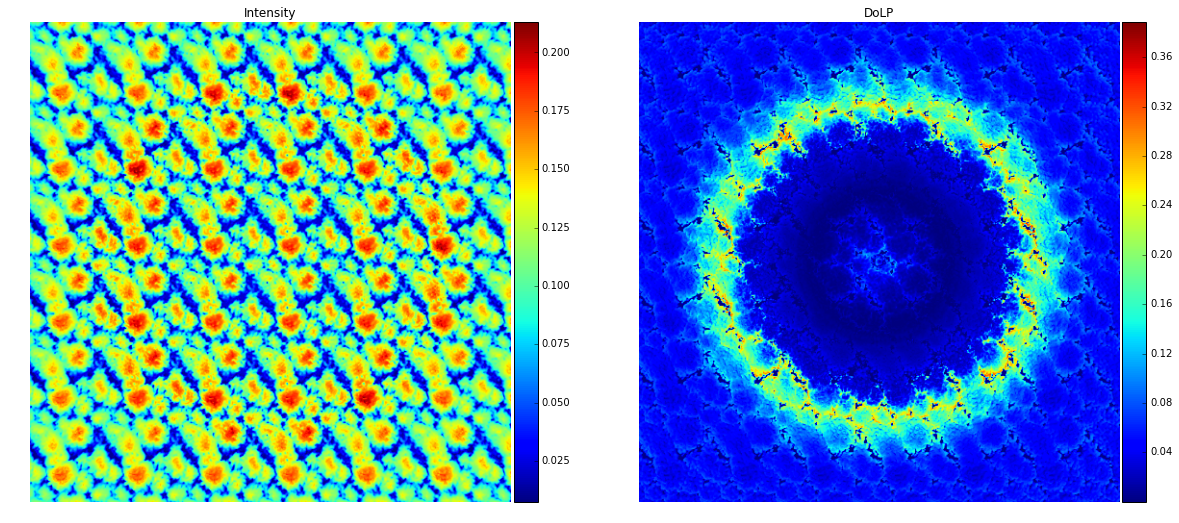

In [33]:
"""
Simulated cloudbow using a perspective camera
"""
projection = shdom.PerspectiveProjection(fov=100, nx=500, ny=500, x=1.75, y=1.75, z=10.0)
projection.look_at_transform(point=[1.75, 1.75, 0.0], up=[1.0, 0.0, 0.0])
camera.set_projection(projection)

stokes, dolp, aolp, docp = camera.render(rte_solver)

%matplotlib inline

imgs = []
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
imgs.append(axes[0].imshow(stokes[0]))
axes[0].set_title('Intensity');
imgs.append(axes[1].imshow(dolp))
axes[1].set_title('DoLP');

for img, ax in zip(imgs, axes):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    img.set_cmap('jet')
    plt.colorbar(img, cax=cax)
    ax.set_axis_off()